In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import commonutils
import models

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from dataclasses import dataclass
import prettyprinter as pp

from sklearn.cross_decomposition import PLSRegression
import warnings
import sys

from sklearn import preprocessing

from copy import deepcopy

In [2]:
warnings.simplefilter("ignore")

supersetnames = {"BARRIER_HEIGHTS" : \
                       ["BH76","BHDIV10","BHPERI",\
                        "BHROT27","INV24","PX13","WCPT18"] \
                    ,"INTRAMOLECULAR_INTERACTIONS" : \
                       ["ACONF",'Amino20x4',"BUT14DIOL",\
                        "ICONF","IDISP","MCONF",\
                        "PCONF21","SCONF","UPU23"] , \
                    "SMALL_MOLECULES" :\
                        ["AL2X6","ALK8","ALKBDE10","BH76RC",\
                         "DC13","DIPCS10","FH51","G21EA",\
                         "G21IP","G2RC","HEAVYSB11","NBPRC",\
                         "PA26","RC21","SIE4x4","TAUT15",\
                         "W4-11","YBDE18"], \
                    "INTERMOLECULAR_INTERACTIONS" :\
                       ["ADIM6","AHB21","CARBHB12",\
                        "CHB6","HAL59","HEAVY28","IL16",\
                        "PNICO23","RG18","S22","S66","WATER27"] , \
                    "LARGE_SYSTEMS" :\
                        ["BSR36","C60ISO","CDIE20","DARC",\
                         "ISO34","ISOL24","MB16-43","PArel",\
                            "RSE43"]}  

howmanydifs = 3
methods = {}
entries = ["Nuclear Repulsion  :", \
        "One Electron Energy:", \
        "Two Electron Energy:", \
        "Potential Energy   :", \
        "Kinetic Energy     :", \
        "E(X)               :"  , \
        "E(C)               :"  , \
        "Dispersion correction", \
        "FINAL SINGLE POINT ENERGY"]
functionals = ["PBE", "PBE0", "TPSS", "TPSSh"]
basis_sets = ["MINIX", "SVP", "TZVP"]
for func in functionals:
    for basis in basis_sets:
        methods[func + "-" + basis] = []
        for ebtry in entries:
            methods[func + "-" + basis].append(ebtry)

# read all the data and initialize the data structures
rootdir = "../datasets/AllData_3/"   
allvalues_perset, fullsetnames, models_results = \
        commonutils.read_and_init (rootdir, supersetnames, howmanydifs, methods, \
                       DEBUG=True)

Reading dataset:  BH76
Number of samples:  76
Number of basic descriptors:  76

Reading dataset:  BHDIV10
Number of samples:  10
Number of basic descriptors:  10

Reading dataset:  BHPERI
Number of samples:  26
Number of basic descriptors:  26

Reading dataset:  BHROT27
Number of samples:  27
Number of basic descriptors:  27

Reading dataset:  INV24
Number of samples:  24
Number of basic descriptors:  24

Reading dataset:  PX13
Number of samples:  13
Number of basic descriptors:  13

Reading dataset:  WCPT18
Number of samples:  18
Number of basic descriptors:  18

Reading dataset:  ACONF
Number of samples:  15
Number of basic descriptors:  15

Reading dataset:  Amino20x4
Number of samples:  80
Number of basic descriptors:  80

Reading dataset:  BUT14DIOL
Number of samples:  64
Number of basic descriptors:  64

Reading dataset:  ICONF
Number of samples:  17
Number of basic descriptors:  17

Reading dataset:  IDISP
Number of samples:  6
Number of basic descriptors:  6

Reading dataset:  

In [3]:
# for debug purposes
#for val in allvalues_perset:
#    print("======= START =======")
#    print(val, len(allvalues_perset[val]))
#    pp.pprint(allvalues_perset[val])
#    print("=======  END  =======")

In [4]:
from importlib import reload
reload(commonutils)

from commonutils import ModelResults

allfeatures = set()
for setname in fullsetnames:
    for val in allvalues_perset[setname]:
        for k in val:
            if k.find("energydiff") != -1:
                for f in val[k]:
                    allfeatures.add(f)

# set labels and sets iists
models_results = {}
for setname in fullsetnames:
    models_results[setname] = ModelResults()
    for val in allvalues_perset[setname]:
        models_results[setname].labels.append(val["label"]) 
        models_results[setname].supersetnames.append(val["super_setname"])
        models_results[setname].setnames.append(val["super_setname"]+"_"+val["setname"])

for setname in fullsetnames:
    for methodid in range(howmanydifs):
        y_pred = []
        for val in allvalues_perset[setname]:
            y_pred.append(val["label"] + val["difs"][methodid])

        wtmadf = commonutils.wtmad2(models_results[setname].setnames, \
                                    models_results[setname].labels, y_pred)
        wtmad = wtmadf["Full"]

        if wtmad < models_results[setname].bestinsidemethod_wtmad:
            models_results[setname].bestinsidemethod_wtmad = wtmad
            models_results[setname].bestinsidemethod_name_wtmad = str(methodid)
            models_results[setname].y_pred_bestinsidemethod_wtmad = y_pred

        rmse = mean_squared_error(models_results[setname].labels, \
                                y_pred, squared=False)

        if rmse < models_results[setname].bestinsidemethod_rmse:
            models_results[setname].bestinsidemethod_rmse = rmse
            models_results[setname].bestinsidemethod_name_rmse = str(methodid)
            models_results[setname].y_pred_bestinsidemethod_rmse = y_pred

    for j, method in enumerate(methods):
        y_pred = []
        for val in allvalues_perset[setname]:
            y_pred.append(val[method + "_energydiff"][method+"_FINAL_SINGLE_POINT_ENERGY"])

        wtmadf = commonutils.wtmad2(models_results[setname].setnames, \
                                models_results[setname].labels, y_pred)
        wtmad = wtmadf["Full"]

        if wtmad < models_results[setname].bestourmethod_wtmad:
            models_results[setname].bestourmethod_wtmad = wtmad
            models_results[setname].bestourmethod_name_wtmad = method
            models_results[setname].y_pred_bestourmethod_wtmad = y_pred
        
        rmse = mean_squared_error(models_results[setname].labels,\
                                y_pred, squared=False)

        if rmse < models_results[setname].bestourmethod_rmse:
            models_results[setname].bestourmethod_rmse = rmse
            models_results[setname].bestourmethod_name_rmse = method
            models_results[setname].y_pred_bestourmethod_rmse = y_pred

print("Results for inside and our methods")
print("%40s"% "Dataset", " , ", \
    "Best inside method RMSE", " , ", \
    "RMSE", " , ", \
    "Best inside method WTMAD2", " , ", \
    "WTMAD2", " , ", \
    "Best our method RMSE", " , ", \
    "RMSE", " , ", \
    "Best our method WTMAD2", " , ", \
    "WTMAD2")
for setname in fullsetnames:
    print("%40s"%setname, " , ", \
        "%10s"%models_results[setname].bestinsidemethod_name_rmse , " , ",\
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%10s"%models_results[setname].bestinsidemethod_name_wtmad , " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_wtmad, " , ", \
        "%10s"%models_results[setname].bestourmethod_name_rmse , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%10s"%models_results[setname].bestourmethod_name_wtmad , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_wtmad)

Results for inside and our methods
                                 Dataset  ,  Best inside method RMSE  ,  RMSE  ,  Best inside method WTMAD2  ,  WTMAD2  ,  Best our method RMSE  ,  RMSE  ,  Best our method WTMAD2  ,  WTMAD2
                         BARRIER_HEIGHTS  ,           0  ,    8.201  ,           0  ,    8.040  ,   PBE0-TZVP  ,    4.856  ,   PBE0-TZVP  ,    4.970
                    BARRIER_HEIGHTS_BH76  ,           0  ,   10.387  ,           0  ,    9.150  ,   PBE0-TZVP  ,    5.505  ,   PBE0-TZVP  ,    5.000
                 BARRIER_HEIGHTS_BHDIV10  ,           0  ,    9.191  ,           0  ,    8.230  ,   PBE0-TZVP  ,    5.278  ,   PBE0-TZVP  ,    4.800
                  BARRIER_HEIGHTS_BHPERI  ,           0  ,    4.407  ,           0  ,    3.950  ,   PBE0-TZVP  ,    3.762  ,   PBE0-TZVP  ,    3.510
                 BARRIER_HEIGHTS_BHROT27  ,           1  ,    0.611  ,           1  ,    0.420  ,    PBE-TZVP  ,    0.718  ,    PBE-TZVP  ,    0.540
                   BARRIER_HE

In [5]:
#build descriptors 
selected_basisset = "TZVP"
selected_functional = "PBE"
functionals = ["PBE", "PBE0", "TPSS", "TPSSh"]
for setname in fullsetnames:
    desciptors = {}
    for val in allvalues_perset[setname]:
        for func in functionals:
            for basis in basis_sets:
                if basis == selected_basisset and func == selected_functional:
                    k = func + "-" + basis + "_energydiff"
                    for k2 in val[k]:
                        if k2 not in desciptors:
                            desciptors[k2] = [val[k][k2]]
                        else:
                            desciptors[k2].append(val[k][k2])
                else:
                    refk  = selected_functional + "-" + selected_basisset + "_energydiff"
                    k = func + "-" + basis + "_energydiff"
                    for k2 in val[k]:
                        refk2 = k2.replace(basis, selected_basisset)
                        refk2 = refk2.replace(func, selected_functional)
                        newk2 = k2 + "_difftoref"
                        if newk2 not in desciptors:
                            desciptors[newk2] = [val[refk][refk2] - val[k][k2]]
                        else:
                            desciptors[newk2].append(val[refk][refk2] - val[k][k2])
    models_results[setname].features = desciptors
    #print("Descriptors for ", setname)
    #for k in desciptors:
    #    print(k, len(desciptors[k]), desciptors[k])

# feastures selection
setname = "Full"
numoffeat = len(models_results[setname].features)
print("Number of features for ", numoffeat)
for setname in fullsetnames:
    if len(models_results[setname].features) != numoffeat:
        print("Number of features for ", setname, " is different")
        sys.exit(1)

toremove = []
setname = "Full"
for k in models_results[setname].features:
    if len(set(models_results[setname].features[k])) == 1:
        toremove.append(k)
        print("Constant fatures to remove: ", k)

# remove constant values
for setname in fullsetnames:
    #print("Removing constant features for ", setname)
    for k in toremove:
        #print("Constant fatures to remove: ", k)
        del models_results[setname].features[k]

# test print for debug
#for setname in fullsetnames:
#    print("Descriptors for ", setname)
#    for k in models_results[setname].features:
#        print(k, len(models_results[setname].features[k]), \
#           models_results[setname].features[k])

# force removing features Nuclear Repulsion difference
print("Removing Nuclear Repulsion difference")
for setname in fullsetnames: 
    toremove = []
    for k in models_results[setname].features:
        if k.find("Nuclear_Repulsion_difftoref") != -1:
            toremove.append(k)
    for k in toremove:
        #print("Removing feature ", k)
        del models_results[setname].features[k]

setname = "Full"
numoffeat = len(models_results[setname].features)
print("Number of features for ", numoffeat)
for setname in fullsetnames:
    if len(models_results[setname].features) != numoffeat:
        print("Number of features for ", setname, " is different")
        sys.exit(1)

Number of features for  108
Constant fatures to remove:  PBE-MINIX_Dispersion_correction_difftoref
Constant fatures to remove:  PBE-SVP_Dispersion_correction_difftoref
Constant fatures to remove:  PBE-SVP_Nuclear_Repulsion_difftoref
Constant fatures to remove:  PBE0-SVP_Nuclear_Repulsion_difftoref
Constant fatures to remove:  PBE0-TZVP_Nuclear_Repulsion_difftoref
Constant fatures to remove:  TPSS-SVP_Nuclear_Repulsion_difftoref
Constant fatures to remove:  TPSS-TZVP_Nuclear_Repulsion_difftoref
Constant fatures to remove:  TPSSh-SVP_Nuclear_Repulsion_difftoref
Constant fatures to remove:  TPSSh-TZVP_Nuclear_Repulsion_difftoref
Removing Nuclear Repulsion difference
Number of features for  95


In [6]:
#for setname in fullsetnames:
#    print("Descriptors for ", setname)
#    for k in models_results[setname].features:
#        print(k, len(models_results[setname].features[k]), \
#           models_results[setname].features[k])

In [7]:
# remove corralted features 
CORRCUT = 0.96

setname = "Full"
touse = []
toremove = []
df = pd.DataFrame(models_results[setname].features)
corr = df.corr().abs()
for i, k in enumerate(corr.columns):
    print(i+1, " - ", k, " ", i)
    if k not in toremove:
        touse.append(k)
    for idx, v in enumerate(corr[k]):
        if v > CORRCUT and idx > i:
            print(" %60s %4.2f"%(corr.index[idx], v))
            toremove.append(corr.index[idx])

print("Features to use")
for i, feat in enumerate(touse):
    print(i+1 ,  " - " , feat)

for setname in fullsetnames:
    for k in touse:
        models_results[setname].uncorrelated_features[k] = \
            deepcopy(models_results[setname].features[k])

1  -  PBE-MINIX_Two_Electron_Energy_difftoref   0
                      PBE-MINIX_One_Electron_Energy_difftoref 1.00
                     PBE0-MINIX_One_Electron_Energy_difftoref 1.00
                     PBE0-MINIX_Two_Electron_Energy_difftoref 1.00
                     TPSS-MINIX_One_Electron_Energy_difftoref 1.00
                     TPSS-MINIX_Two_Electron_Energy_difftoref 1.00
                    TPSSh-MINIX_One_Electron_Energy_difftoref 1.00
                    TPSSh-MINIX_Two_Electron_Energy_difftoref 1.00
2  -  PBE-MINIX_Kinetic_Energy_difftoref   1
                         PBE-MINIX_Potential_Energy_difftoref 1.00
                          PBE0-MINIX_Kinetic_Energy_difftoref 0.99
                        PBE0-MINIX_Potential_Energy_difftoref 0.99
                          TPSS-MINIX_Kinetic_Energy_difftoref 1.00
                        TPSS-MINIX_Potential_Energy_difftoref 0.99
                       TPSSh-MINIX_Potential_Energy_difftoref 0.99
                         TPSSh-MIN

Correlation matrix


<Axes: >

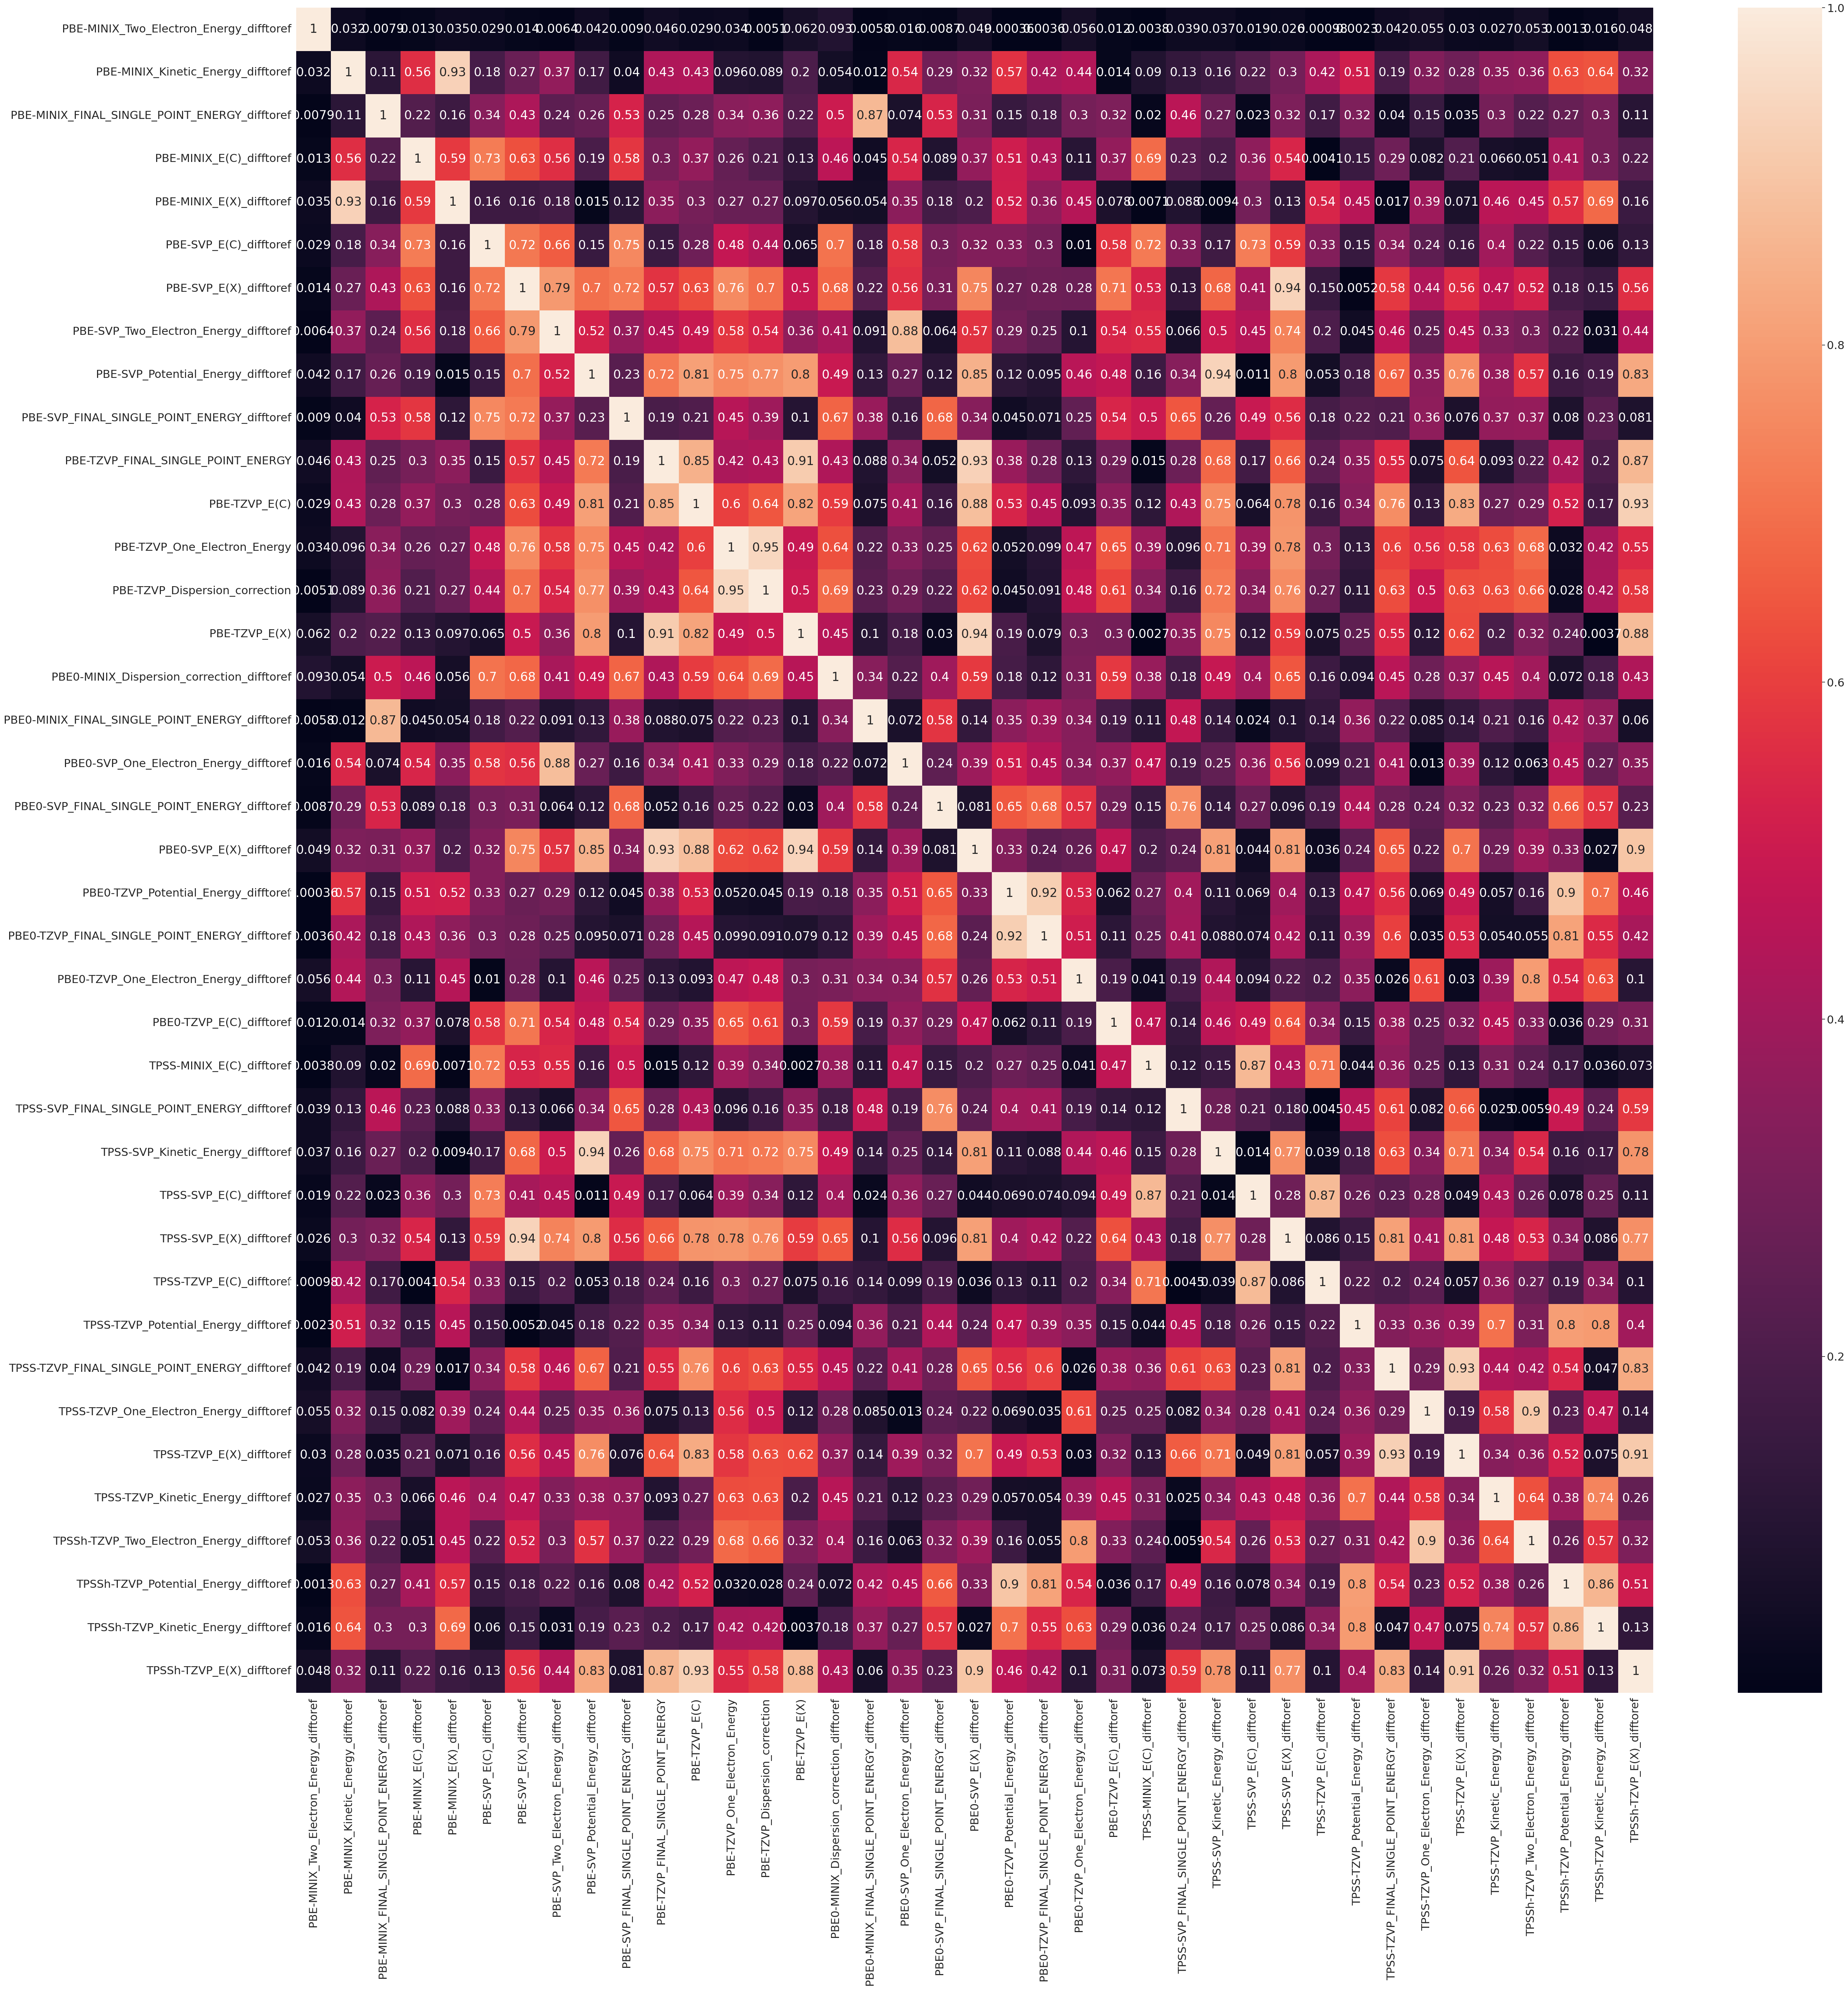

In [8]:
#for setname in fullsetnames:
#    print("Descriptors for ", setname)
#    i = 1
#    for k in models_results[setname].features:
#        print(i, " - ", k, len(models_results[setname].features[k]), \
#           models_results[setname].features[k])
#        i += 1

import seaborn as sns
%matplotlib inline

setname = "Full"
df = pd.DataFrame(models_results[setname].uncorrelated_features)
print("Correlation matrix")
plt.rcParams['figure.figsize'] = 60,60
sns.set(font_scale=2)
sns.heatmap(df.corr().abs(), annot=True)
#print(df.corr().abs())
#sns.heatmap(df, annot=True)

In [9]:
import importlib
importlib.reload(models)
importlib.reload(commonutils)

perc_split = 0.2
for setname in list(supersetnames)+["Full"]:
   print("Running PLS for dataset: ", setname)

   X, Y, features_names = \
      commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
              models_results[setname].labels)
   setlist = []
   for i, s in enumerate(models_results[setname].setnames):
        ss = models_results[setname].supersetnames[i]
        setlist.append(ss + "_" + s)   
   supersetlist = models_results[setname].supersetnames
   maxcomp = X.shape[1]
   ncomps, rmses, r2s, wtmads = \
          models.pls_model (perc_split, X, Y, supersetlist, setlist, \
          ncomp_start = 1, ncomp_max = maxcomp, split = False)
   r2max_comps = np.argmax(r2s)+1
   rmsemin_comps = np.argmin(rmses)+1
   wtmadmin_comps = np.argmin(wtmads)+1
   print("Best number of components for R2: ", r2max_comps)
   print("Best number of components for RMSE: ", rmsemin_comps)
   print("Best number of components for WTMAD: ", wtmadmin_comps)
   compstouse = wtmadmin_comps
   rmse_train, rmse_test, r2_train, \
      r2_test, rmse_full, r2_full , \
      models_results[setname].plsmodel, \
      X_train, X_test, y_train, y_test  = \
              models.pls_model (perc_split, X, Y, supersetlist, setlist, \
                                False, compstouse, split = False)
   
   models_results[setname].y_pred = \
      models_results[setname].plsmodel.predict(X) 

Running PLS for dataset:  BARRIER_HEIGHTS
Best number of components for R2:  39
Best number of components for RMSE:  39
Best number of components for WTMAD:  26
Running PLS for dataset:  INTRAMOLECULAR_INTERACTIONS
Best number of components for R2:  39
Best number of components for RMSE:  39
Best number of components for WTMAD:  16
Running PLS for dataset:  SMALL_MOLECULES
Best number of components for R2:  39
Best number of components for RMSE:  39
Best number of components for WTMAD:  28
Running PLS for dataset:  INTERMOLECULAR_INTERACTIONS
Best number of components for R2:  39
Best number of components for RMSE:  39
Best number of components for WTMAD:  39
Running PLS for dataset:  LARGE_SYSTEMS
Best number of components for R2:  39
Best number of components for RMSE:  39
Best number of components for WTMAD:  38
Running PLS for dataset:  Full
Best number of components for R2:  39
Best number of components for RMSE:  39
Best number of components for WTMAD:  35


In [10]:
print(" Dim , %40s"% "Dataset", " , ", \
      "Best inside method RMSE", " , ", \
      "Best our method RMSE", " , ", \
      "RMSE (superset) ," + \
      "RMSE (Full)")
pls_model_full = models_results["Full"].plsmodel
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results["Full"].uncorrelated_features, \
                                    models_results["Full"].labels)
y_pred = pls_model_full.predict(X)
rmse = mean_squared_error(Y, y_pred, squared=False)
r2 = r2_score(Y, y_pred)
print("%4d , %40s"%(len(models_results["Full"].labels), "Full"), " , ", \
    "%7.3f"%models_results["Full"].bestinsidemethod_rmse, " , ", \
    "%7.3f"%models_results["Full"].bestourmethod_rmse, " , ", \
    "%7.3f"%rmse, " , ", \
    "%7.3f"%rmse)

for ssetname in supersetnames:
    pls_model_ssetname = models_results[ssetname].plsmodel
    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[ssetname].uncorrelated_features, \
                                    models_results[ssetname].labels)
    y_pred = pls_model_ssetname.predict(X)
    rmse = mean_squared_error(Y, y_pred, squared=False)

    y_pred_full = pls_model_full.predict(X) 
    rmse_full = mean_squared_error(Y, y_pred_full, squared=False)

    print("%4d , %40s"%(len(models_results[ssetname].labels), ssetname), " , ", \
        "%7.3f"%models_results[ssetname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[ssetname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse, " , ", \
        "%7.3f"%rmse_full)
    
    for isetname in supersetnames[ssetname]:
        setname = ssetname + "_" + isetname 
        X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
                                    models_results[setname].labels)

        y_pred_ssetname = pls_model_ssetname.predict(X)
        rmse_ssetname = mean_squared_error(Y, y_pred_ssetname, squared=False)

        y_pred_full = pls_model_full.predict(X)
        rmse_full = mean_squared_error(Y, y_pred_full, squared=False)

        print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
            "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
            "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
            "%7.3f"%rmse_ssetname, " , ", \
            "%7.3f"%rmse_full)


 Dim ,                                  Dataset  ,  Best inside method RMSE  ,  Best our method RMSE  ,  RMSE (superset) ,RMSE (Full)
1505 ,                                     Full  ,    9.227  ,    6.219  ,    3.386  ,    3.386
 194 ,                          BARRIER_HEIGHTS  ,    8.201  ,    4.856  ,    1.018  ,    2.026
  76 ,                     BARRIER_HEIGHTS_BH76  ,   10.387  ,    5.505  ,    0.905  ,    1.777
  10 ,                  BARRIER_HEIGHTS_BHDIV10  ,    9.191  ,    5.278  ,    1.685  ,    3.297
  26 ,                   BARRIER_HEIGHTS_BHPERI  ,    4.407  ,    3.762  ,    0.836  ,    2.218
  27 ,                  BARRIER_HEIGHTS_BHROT27  ,    0.611  ,    0.718  ,    0.426  ,    0.657
  24 ,                    BARRIER_HEIGHTS_INV24  ,    2.658  ,    1.534  ,    1.193  ,    3.020
  13 ,                     BARRIER_HEIGHTS_PX13  ,   11.730  ,    8.204  ,    1.080  ,    1.222
  18 ,                   BARRIER_HEIGHTS_WCPT18  ,    8.999  ,    5.887  ,    1.453  ,    1.969
 2

Results for  BARRIER_HEIGHTS  dim:  194
WTAMD2     (PLS ssetname)   1.020
WTAMD2         (PLS Full)   1.970
WTAMD2 (bestinsidemethod)   8.040
WTAMD2    (bestourmethod)   4.970
RMSE       (PLS ssetname)   1.018
RMSE           (PLS Full)   2.026
RMSE   (bestinsidemethod)   8.201
RMSE      (bestourmethod)   4.856


<Figure size 1000x1000 with 0 Axes>

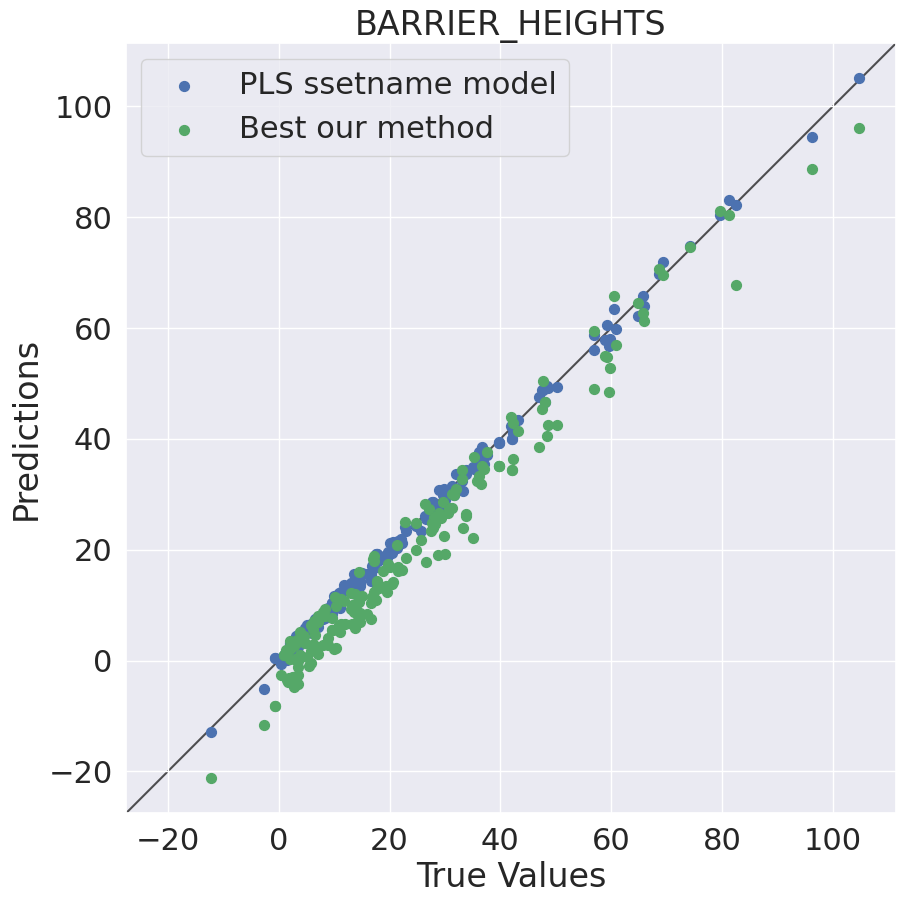

Results for  INTRAMOLECULAR_INTERACTIONS  dim:  291
WTAMD2     (PLS ssetname)   0.220
WTAMD2         (PLS Full)   0.900
WTAMD2 (bestinsidemethod)   0.690
WTAMD2    (bestourmethod)   0.640
RMSE       (PLS ssetname)   0.216
RMSE           (PLS Full)   0.753
RMSE   (bestinsidemethod)   0.873
RMSE      (bestourmethod)   0.589


<Figure size 1000x1000 with 0 Axes>

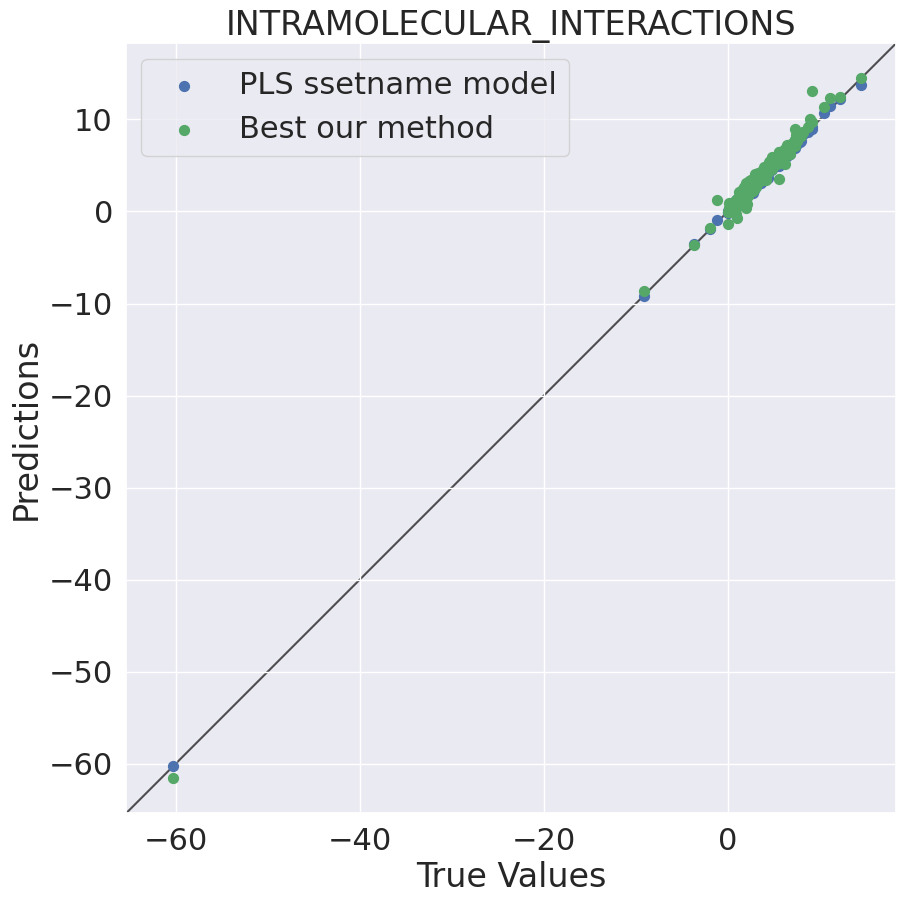

Results for  SMALL_MOLECULES  dim:  473
WTAMD2     (PLS ssetname)   5.780
WTAMD2         (PLS Full)   6.510
WTAMD2 (bestinsidemethod)  13.010
WTAMD2    (bestourmethod)  10.140
RMSE       (PLS ssetname)   4.274
RMSE           (PLS Full)   4.816
RMSE   (bestinsidemethod)  12.191
RMSE      (bestourmethod)   6.291


<Figure size 1000x1000 with 0 Axes>

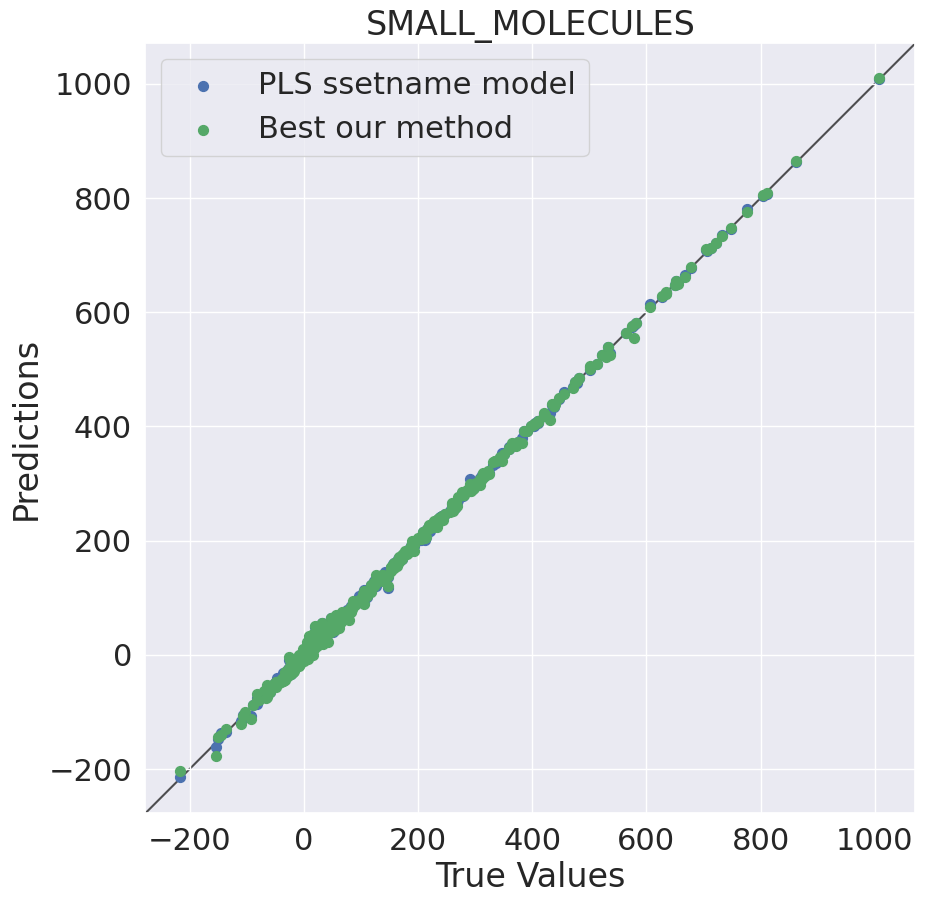

Results for  INTERMOLECULAR_INTERACTIONS  dim:  304
WTAMD2     (PLS ssetname)   1.510
WTAMD2         (PLS Full)   4.900
WTAMD2 (bestinsidemethod)   3.720
WTAMD2    (bestourmethod)   4.020
RMSE       (PLS ssetname)   0.435
RMSE           (PLS Full)   1.550
RMSE   (bestinsidemethod)   2.286
RMSE      (bestourmethod)   5.970


<Figure size 1000x1000 with 0 Axes>

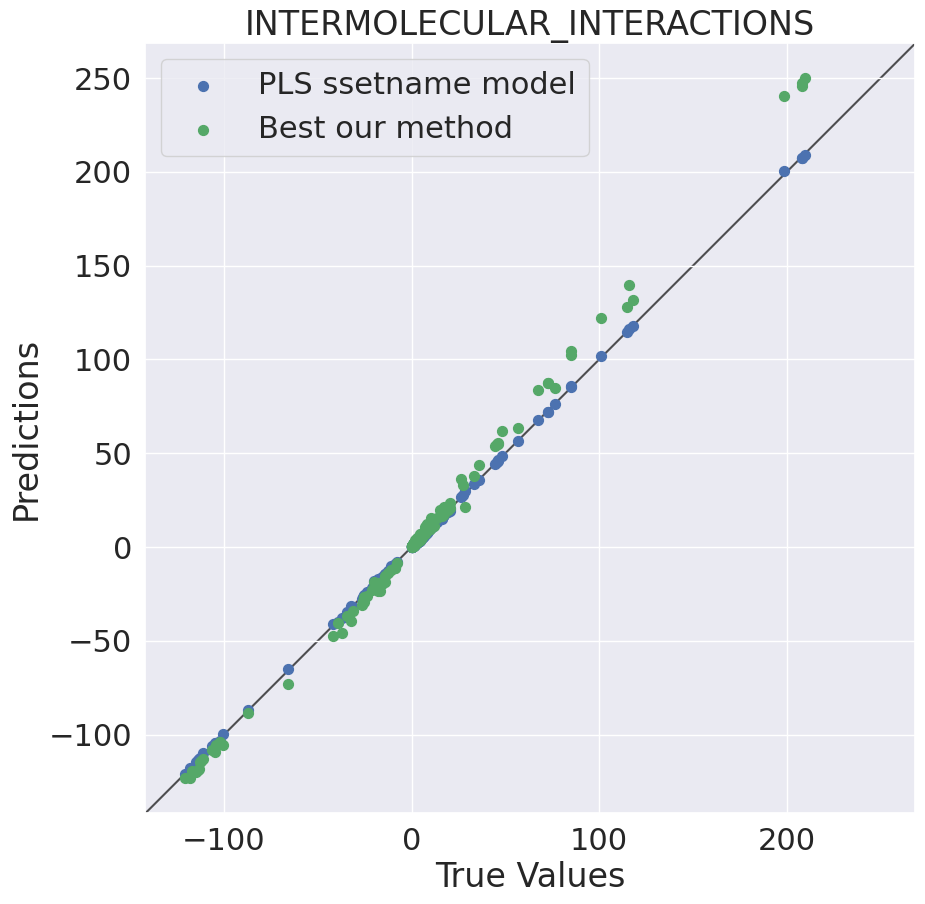

Results for  LARGE_SYSTEMS  dim:  243
WTAMD2     (PLS ssetname)   7.890
WTAMD2         (PLS Full)   8.490
WTAMD2 (bestinsidemethod)  16.050
WTAMD2    (bestourmethod)  11.320
RMSE       (PLS ssetname)   2.323
RMSE           (PLS Full)   4.350
RMSE   (bestinsidemethod)  12.567
RMSE      (bestourmethod)   9.042


<Figure size 1000x1000 with 0 Axes>

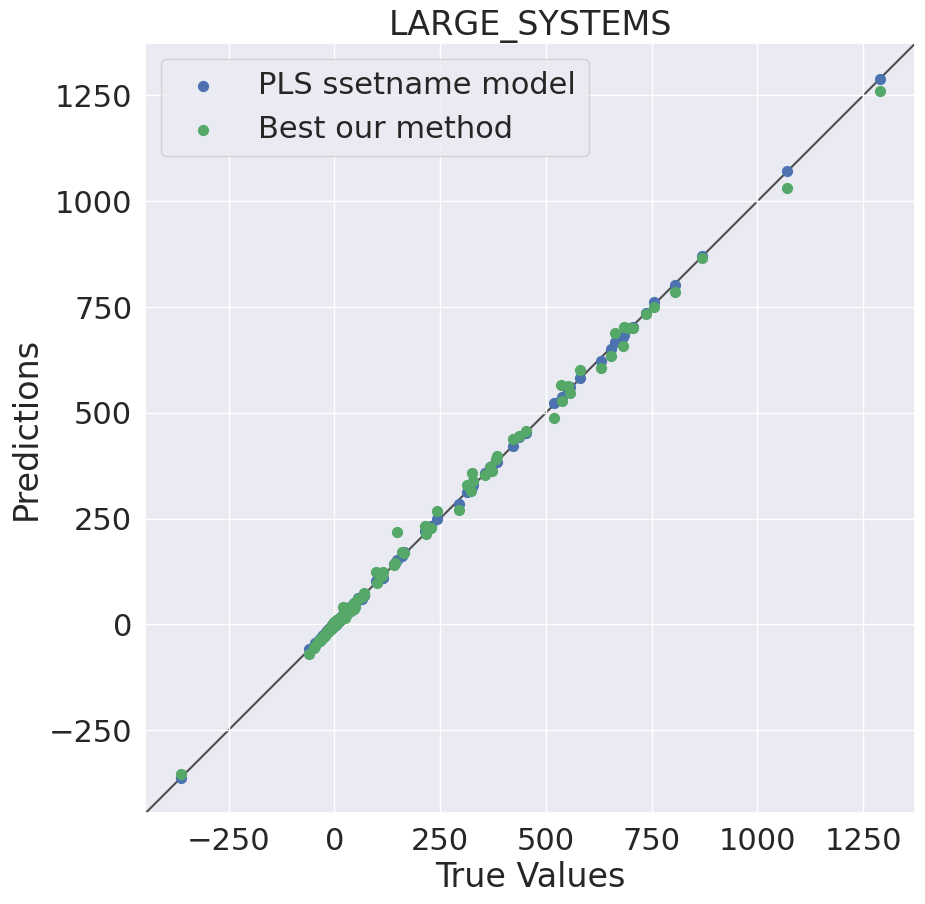

Results for Full sim  1505
WTAMD2     (PLS ssetname)   3.530
WTAMD2         (PLS Full)   7.360
WTAMD2 (bestinsidemethod)  10.160
WTAMD2    (bestourmethod)   8.160
RMSE       (PLS ssetname)   2.606
RMSE           (PLS Full)   3.386
RMSE   (bestinsidemethod)   9.227
RMSE      (bestourmethod)   6.219


<Figure size 1000x1000 with 0 Axes>

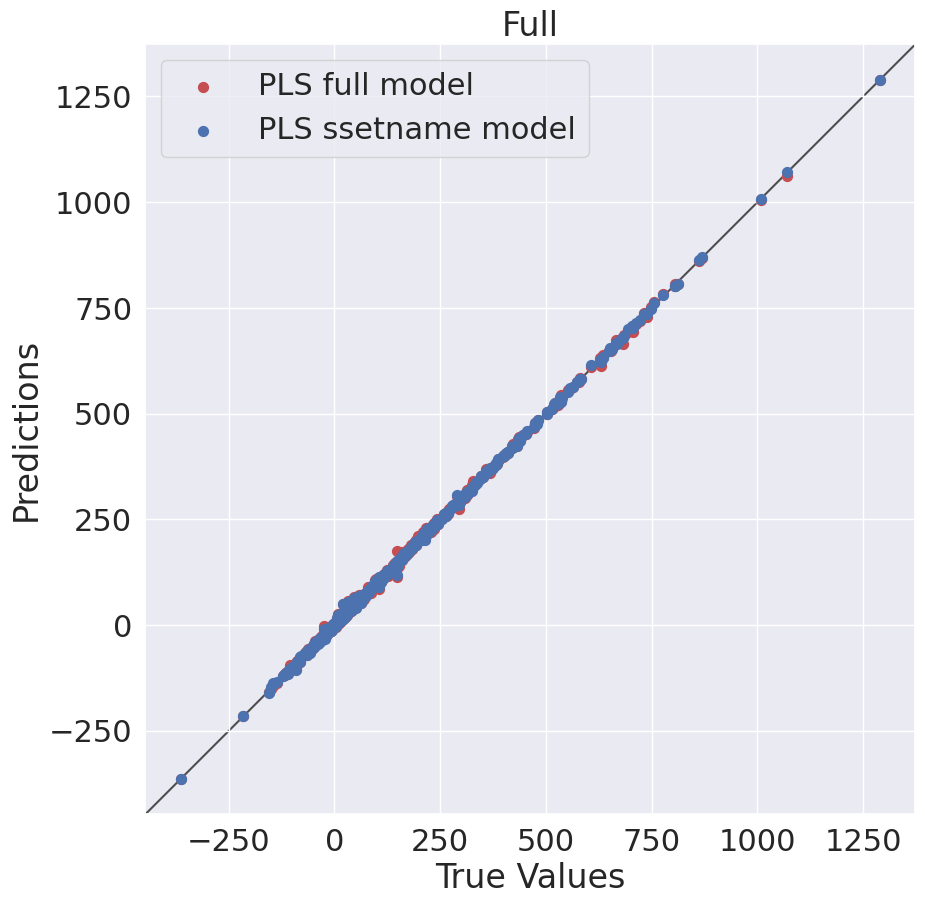

In [13]:
setname = "Full"
pls_model_full = models_results[setname].plsmodel
printonlysuperset = True
setnametouse = deepcopy(fullsetnames)
setnametouse.remove("Full")

ypredFull = []
setnamesFull = []

for setname in setnametouse:
    if setname in supersetnames:
        ssetname = setname  
    else:    
        lastunder = setname.rfind("_")
        ssetname = setname[:lastunder]
    
    pls_model_ssetname = models_results[ssetname].plsmodel
    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
                                    models_results[setname].labels)
    setlist = []
    for i, s in enumerate(models_results[setname].setnames):
        ss = models_results[setname].supersetnames[i]
        setlist.append(ss + "_" + s)   
    
    y_pred_full = pls_model_full.predict(X)
    if len(y_pred_full.shape) == 2:
        y_pred_full = y_pred_full[:,0]
    rmse_full = mean_squared_error(Y, y_pred_full, squared=False)

    y_pred = pls_model_ssetname.predict(X)
    if len(y_pred.shape) == 2:
        y_pred = y_pred[:,0]
    rmse = mean_squared_error(Y, y_pred, squared=False)
    
    if setname in supersetnames:
        ypredFull.extend(list(y_pred))
        setnamesFull.extend(setlist)
        print("Results for ", setname, " dim: ", len(Y))
        wtmad2df = commonutils.wtmad2(setlist, Y, y_pred)
        wtmad2_fulldf = commonutils.wtmad2(setlist, Y, y_pred_full)
        wtmad2 = wtmad2df["Full"]
        wtmad2_full = wtmad2_fulldf["Full"]
        print("WTAMD2     (PLS ssetname) %7.3f"%wtmad2)
        print("WTAMD2         (PLS Full) %7.3f"%wtmad2_full)
        print("WTAMD2 (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_wtmad) 
        print("WTAMD2    (bestourmethod) %7.3f"%models_results[setname].bestourmethod_wtmad)
        
    if printonlysuperset and setname not in list(supersetnames.keys()) + ["Full"]:
        continue

    print("RMSE       (PLS ssetname) %7.3f"%rmse)
    print("RMSE           (PLS Full) %7.3f"%rmse_full,)
    print("RMSE   (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_rmse)
    print("RMSE      (bestourmethod) %7.3f"%models_results[setname].bestourmethod_rmse)
    
    plt.clf()
    plt.rcParams['figure.figsize'] = 10,10
    fig, ax = plt.subplots()
    ax.scatter(Y, y_pred, c='b', s=50, label='PLS ssetname model')
    #ax.scatter(Y, y_pred_full, c='y', s=50, label='PLS full model')
    #ax.scatter(Y, models_results[setname].y_pred_bestinsidemethod, \
    #            c='r', s=50, label='Best inside method')
    ax.scatter(Y, models_results[setname].y_pred_bestourmethod_rmse, \
               c='g', s=50, label='Best our method')
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend(loc="upper left")
    plt.title(setname)
    plt.show()

print("Results for Full sim ", len(ypredFull))
X, Y, features_names = \
        commonutils.build_XY_matrix (models_results["Full"].uncorrelated_features, \
                                    models_results["Full"].labels)
setlist = []
for i, s in enumerate(models_results["Full"].setnames):
    ss = models_results["Full"].supersetnames[i]
    setlist.append(ss + "_" + s)   
    
wtmad2df = commonutils.wtmad2(setnamesFull, Y, ypredFull)
wtmad2 = wtmad2df["Full"]
rmse = mean_squared_error(Y, ypredFull, squared=False)

y_pred_full = pls_model_full.predict(X)
if len(y_pred_full.shape) == 2:
    y_pred_full = y_pred_full[:,0]
rmse_full = mean_squared_error(Y, y_pred_full, squared=False)
wtmad2_fulldf = commonutils.wtmad2(setlist, Y, y_pred_full)
wtmad2_full = wtmad2_fulldf["Full"]

print("WTAMD2     (PLS ssetname) %7.3f"%wtmad2)
print("WTAMD2         (PLS Full) %7.3f"%wtmad2_full)
print("WTAMD2 (bestinsidemethod) %7.3f"%models_results["Full"].bestinsidemethod_wtmad)
print("WTAMD2    (bestourmethod) %7.3f"%models_results["Full"].bestourmethod_wtmad)
rmse = mean_squared_error(models_results["Full"].labels, ypredFull, squared=False)
print("RMSE       (PLS ssetname) %7.3f"%rmse)
print("RMSE           (PLS Full) %7.3f"%rmse_full)
print("RMSE   (bestinsidemethod) %7.3f"%models_results["Full"].bestinsidemethod_rmse)
print("RMSE      (bestourmethod) %7.3f"%models_results["Full"].bestourmethod_rmse)

plt.clf()
plt.rcParams['figure.figsize'] = 10,10
fig, ax = plt.subplots()
ax.scatter(Y, y_pred_full, c='r', s=50, label='PLS full model')
ax.scatter(Y, ypredFull, c='b', s=50, label='PLS ssetname model')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend(loc="upper left")
plt.title("Full")
plt.show()


In [12]:
#test and dump PLS equations
setname = "Full"
pls_model_full = models_results[setname].plsmodel

for setname in fullsetnames:
    print("Equations for dataset: ", setname)
    ssetname = "Full"
    if setname in supersetnames or setname == "Full":
        ssetname = setname  
    else:    
        lastunder = setname.rfind("_")
        ssetname = setname[:lastunder]
    
    pls_model_ssetname = models_results[ssetname].plsmodel
    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
                                    models_results[setname].labels)
    
    y_pred_full = pls_model_full.predict(X)
    rmse_full = mean_squared_error(Y, y_pred_full, squared=False)
    r2_full = r2_score(Y, y_pred_full)
    X_e = X.copy()
    X_e -= pls_model_full._x_mean
    X_e /= pls_model_full._x_std
    y_pred_full_e = np.dot(X_e, pls_model_full.coef_.T)
    y_pred_full_e += pls_model_full._y_mean
    rmse_full_e = mean_squared_error(Y, y_pred_full_e, squared=False)
    print("   Full dataset equations Y mean %7.3f"%pls_model_full._y_mean)
    for i, f in enumerate(features_names):
        print(" %50s %7.3f [%15.3f %15.3f]"%(f, \
            pls_model_full.coef_.T[i],
            pls_model_full._x_mean[i], 
            pls_model_full._x_std[i]))

    y_pred = pls_model_ssetname.predict(X)
    rmse = mean_squared_error(Y, y_pred, squared=False)
    r2 = r2_score(Y, y_pred)
    X_e = X.copy()
    X_e -= pls_model_ssetname._x_mean
    X_e /= pls_model_ssetname._x_std
    y_pred_e = np.dot(X_e, pls_model_ssetname.coef_.T)
    y_pred_e += pls_model_ssetname._y_mean
    rmse_e = mean_squared_error(Y, y_pred_e, squared=False)
    for i, f in enumerate(features_names):
        print(" %50s %7.3f [%15.3f %15.3f]"%(f, \
            pls_model_ssetname.coef_.T[i],
            pls_model_ssetname._x_mean[i], 
            pls_model_ssetname._x_std[i]))

    print()
    print("RMSE         (ssetname) %7.3f from eq. %7.3f diff []"%(rmse, rmse_e))
    print("RMSE             (Full) %7.3f from eq. %7.3f diff []"%(rmse_full, rmse_full_e))  
    print("RMSE (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_rmse)
    print("RMSE    (bestourmethod) %7.3f"%models_results[setname].bestourmethod_rmse)
    print()


Equations for dataset:  BARRIER_HEIGHTS
   Full dataset equations Y mean  61.604
            PBE-MINIX_Two_Electron_Energy_difftoref  -0.287 [      -1680.625        9427.270]
                 PBE-MINIX_Kinetic_Energy_difftoref   0.528 [        -92.341         566.936]
      PBE-MINIX_FINAL_SINGLE_POINT_ENERGY_difftoref   1.287 [         -0.169          32.537]
                           PBE-MINIX_E(C)_difftoref  -8.526 [          0.288           2.495]
                           PBE-MINIX_E(X)_difftoref  -0.409 [         11.015          96.114]
                             PBE-SVP_E(C)_difftoref  -3.747 [          0.145           1.746]
                             PBE-SVP_E(X)_difftoref  14.347 [          4.240          18.403]
              PBE-SVP_Two_Electron_Energy_difftoref   5.539 [        -16.789         111.117]
                 PBE-SVP_Potential_Energy_difftoref   0.445 [         40.851         143.813]
        PBE-SVP_FINAL_SINGLE_POINT_ENERGY_difftoref  11.205 [         -0.